In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report

# Задача 1

# Данные

**Поля:**
Каждая строка данного файла представляет собой граф с:

*node_feat*: узлы

*edge_index*: пары узлов, образующих ребра

*edge_attr* (список: #ребра x #элементы-ребра): для вышеупомянутых ребер содержит их элементы

*y* : содержит количество меток, доступных для прогнозирования (здесь 1, равно нулю или единице)

*num_nodes* : количество узлов графа


**Краткое описание набора данных**
Набор данных по СПИДу - это набор данных, содержащий соединения, проверенные на наличие признаков активности против ВИЧ.

Ссылка на данные: https://huggingface.co/datasets/graphs-datasets/AIDS

In [3]:
df = pd.read_parquet("hf://datasets/graphs-datasets/AIDS/data/full-00000-of-00001-2a1e5fb28f54a227.parquet")
df

,edge_index,node_feat,edge_attr,y,num_nodes
0,"[[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, ...",[0],47
1,"[[0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5,...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...",[1],11
2,"[[0, 0, 0, 1, 1, 2, 3, 3, 4, 4, 5, 6, 6, 7, 7,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, ...",[1],9
3,"[[0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 6, 7,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, ...",[1],10
4,"[[0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, ...",[0],16
...,...,...,...,...,...
1995,"[[0, 0, 1, 1, 1, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, ...",[1],12
1996,"[[0, 1, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...",[1],11
1997,"[[0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, ...",[0],40
1998,"[[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, ...",[0],76


Добавим веса в графы на основе информации из столбца edge_attr. Весом будем считаться индекс признака + 1

Т.е. ребро с атрибутом [1.0, 0.0, 0.0] - будет с весом 1, а ребро с атрибутом [0.0, 1.0, 0.0] - будет с весом 2 и т.п.

In [4]:
def get_weigh_graph(df: pd.DataFrame) -> list[nx.Graph]:
    list_graphs = []
    
    for graph_id in df.index:
        G = nx.Graph()

        list_weighted_grah = [(start_node, end_node, feat.argmax() + 1) 
        for start_node, end_node, feat in zip(
            df['edge_index'][graph_id][0], 
            df['edge_index'][graph_id][1], 
            df['edge_attr'][graph_id])]
        
        G.add_weighted_edges_from(list_weighted_grah)
        list_graphs.append(G)
    return list_graphs

In [5]:
list_graphs = get_weigh_graph(df)
y = [i[0] for i in df.y]

Примеры графов

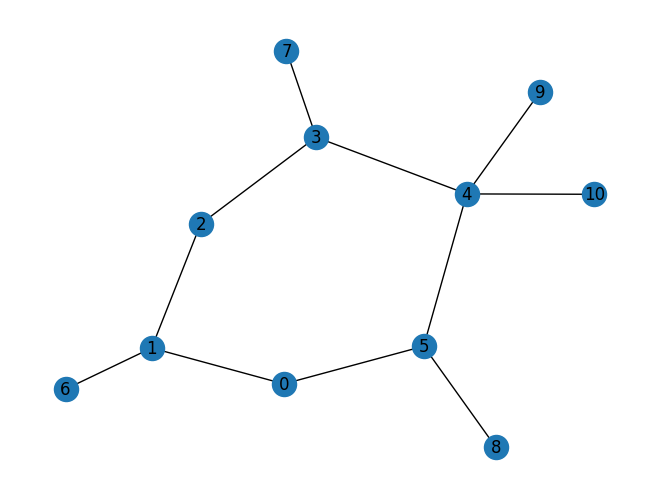

In [6]:
nx.draw(list_graphs[1], with_labels=True)

## Делим данные

In [7]:
train_graphs, test_graphs, y_train, y_test = train_test_split(list_graphs, y, test_size=0.1, stratify=y)

# Shortest Path Kernel

In [13]:
def graph_to_vector(G, max_length=16):
    # считаем словарь с кротчайшими путями для каждой вершины
    path_lengths = nx.shortest_path_length(G)
    vector = np.zeros(max_length, dtype=int)

    for _, lengths in path_lengths:
        for length in lengths.values():
            if length == 0:
                continue
            length = min(length, max_length)
            vector[length-1] += 1
    return vector

def shortest_path_kernel(train_graphs, test_graphs, use_norm = False):
    vectors_train = np.array([graph_to_vector(G) for G in train_graphs])
    vectors_test = np.array([graph_to_vector(G) for G in test_graphs])

    K_train = np.matmul(vectors_train, vectors_train.T)
    K_test = np.matmul(vectors_test, vectors_train.T)

    if use_norm:
        # Нормализуем вектора
        vectors_train_norm = np.linalg.norm(vectors_train, keepdims=True, axis=1)
        vectors_test_norm = np.linalg.norm(vectors_test, keepdims=True, axis=1)
        K_train = K_train / vectors_train_norm / vectors_train_norm.T
        K_test = K_test / vectors_test_norm / vectors_train_norm.T

    return K_train, K_test

In [14]:
K_train, K_test = shortest_path_kernel(train_graphs, test_graphs, False)

In [15]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'precomputed']}  

grid = GridSearchCV(SVC(), param_grid, refit = True) 
grid.fit(K_train, y_train)

grid_predictions_not_norm = grid.predict(K_test) 
print(classification_report(y_test, grid_predictions_not_norm))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.99      1.00      0.99       160

    accuracy                           0.99       200
   macro avg       0.99      0.97      0.98       200
weighted avg       0.99      0.99      0.99       200



## С использованием нормировки (косинусовое расстояние)

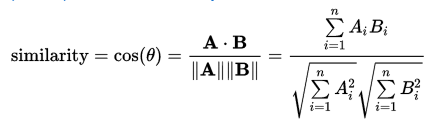

In [16]:
K_train, K_test = shortest_path_kernel(train_graphs, test_graphs, True)

In [17]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'precomputed']}  

grid = GridSearchCV(SVC(), param_grid, refit = True) 
grid.fit(K_train, y_train)

grid_predictions_with_norm = grid.predict(K_test) 
print(classification_report(y_test, grid_predictions_with_norm)) 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.99      1.00      0.99       160

    accuracy                           0.99       200
   macro avg       0.99      0.97      0.98       200
weighted avg       0.99      0.99      0.99       200



# Weisfeiler-Lehman Kernel

In [11]:
def weisfeiler_lehman_kernel(train_graphs, test_graphs, iteration=5):
    K_train = np.zeros((len(train_graphs), len(train_graphs)))
    K_test = np.zeros((len(test_graphs), len(train_graphs)))
    # Список с результатами раскраски
    train_graphs_labels = [weisfeiler_lehman_labels(G, iteration) for G in train_graphs]
    test_graphs_labels = [weisfeiler_lehman_labels(G, iteration) for G in test_graphs]

    # Вычесление каждой ячейки K_train
    for i in range(len(train_graphs)):
        for j in range(i, len(train_graphs)):
            # Вычисление значения ядра
            kernel_value = weisfeiler_lehman_kernel_value(train_graphs_labels[i], train_graphs_labels[j])
            K_train[i, j] = kernel_value
            # Отзеркаливаем значения ядра по диагонали
            K_train[j, i] = kernel_value

    # Вычесление каждой ячейки K_train
    for i in range(len(test_graphs)):
        for j in range(len(train_graphs)):
            # Вычисление значения ядра
            kernel_value = weisfeiler_lehman_kernel_value(test_graphs_labels[i], train_graphs_labels[j])
            K_test[i, j] = kernel_value

    return K_train, K_test

def weisfeiler_lehman_labels(graph, iteration):
    # Иницилизируем все цвета степенью вершины
    labels = {node: str(graph.degree(node)) for node in graph.nodes()}

    for _ in range(iteration):
        # Вычислим новые цвета на основе соседей
        new_labels = {}
        for node in graph.nodes():
            neighbors = graph.neighbors(node)
            # Цвет ноды + отсортированные цвета соседних вершин
            new_label = [labels[node]] + sorted([labels[neighbor] for neighbor in neighbors])
            new_label = ",".join(new_label)

            # Запомним новый цвет вершины (берем хеш для экономии памяти)
            new_labels[node] = str(hash(new_label))
            # new_labels[node] = new_label
        # Обновим цвета
        labels = new_labels
    return labels

def weisfeiler_lehman_kernel_value(labels_i, labels_j):
    # Считаем количество каждого цвета в каждом графе
    kernel_value = 0
    counts_i = defaultdict(int)
    counts_j = defaultdict(int)
    for label in labels_i.values():
        counts_i[label] += 1
    for label in labels_j.values():
        counts_j[label] += 1
    # Считаем вектор, как скалярное произведение встречаемости всех цветов
    for label in set(counts_i.keys()).union(counts_j.keys()):
        kernel_value += counts_i[label] * counts_j[label]
    return kernel_value

In [12]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'precomputed']}  

for iteration in range(1, 6):
    print(f'weisfeiler lehman с {iteration} итерациями:')
    K_train_wl, K_test_wl = weisfeiler_lehman_kernel(train_graphs, test_graphs, iteration)

    wl_grid = GridSearchCV(SVC(), param_grid, refit = True) 
    wl_grid.fit(K_train_wl, y_train)

    wl_grid_predictions_with_norm = wl_grid.predict(K_test_wl) 
    print(classification_report(y_test, wl_grid_predictions_with_norm)) 

weisfeiler lehman с 1 итерациями:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.99      1.00      0.99       160

    accuracy                           0.99       200
   macro avg       0.99      0.97      0.98       200
weighted avg       0.99      0.99      0.99       200

weisfeiler lehman с 2 итерациями:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.99      1.00      0.99       160

    accuracy                           0.99       200
   macro avg       0.99      0.97      0.98       200
weighted avg       0.99      0.99      0.99       200

weisfeiler lehman с 3 итерациями:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        40
           1       0.94      1.00      0.97       160

    accuracy                           0.95       200
   macro avg       0.97   

**Вывод:** так как в наборе данных графы не большие - это приводит к тому, что при больших количествах итераций раскраски графов точность падает.
Также это связано с тем, что сложнее найти большой изоморфный подграф в другом графе (с большим количеством вершин)